In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from DSH import MIfile as MI

In [2]:
froot = 'C:\\Users\\steaime\\Documents\\Research\\MyProjects\\Fracking\\DataDSH_Sabba\\CMAP_mv_avg_S54\\'
fname = froot + 'mv_corr_map_d1.dat'
metadata_fname = froot + 'metadata.ini'
test = MI.MIfile(fname, metadata_fname)

Reading config file: C:\Users\steaime\Documents\Research\Codes\DSH\DSHpy\DSH\config_MIfile.ini


In [3]:
test

<MIfile: 0+100x512x640x4 bytes>

In [4]:
print(test)


|---------------|
| MIfile class: |
|---------------|
 Filename     : C:\Users\steaime\Documents\Research\MyProjects\Fracking\DataDSH_Sabba\CMAP_mv_avg_S54\mv_corr_map_d1.dat
 Header       : 0bytes
 Shape        : [100, 512, 640]px
 Pixel format : f (4 bytes/px)
-----------------


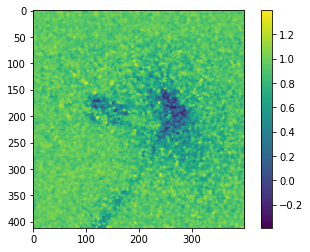

In [9]:
test.OpenForReading()
plt.imshow(test.GetImage(50, cropROI=[200, 100, 400, -1]))
plt.colorbar()